We try to classify breast cancer tumors as malignant or benign based on a sample of cell nuclei. This project is based on a May 2022 Erd&#337; Institute problem set originally written by Matthew Tyler Osborne. I've changed quite a lot so the code no longer bears any resemblance to the the problem set.

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the data

The beast cancer data we use is built into scikit-learn. A fine needle aspirate (FNA) is taken and the data are statistics of a sample of nuclei from the aspirate. We start with 10 geometric attributes: radius, texture, smoothness, etc. Each of these attributes contributes 3 statistics through its sample mean, maximum value (called worst), and standard error. This leads to 30 features in total.

In [54]:
from sklearn.datasets import load_breast_cancer

In [55]:
cancer = load_breast_cancer(as_frame=True) # returns Bunch, an extension of dict, containing pandas DataFrames
X = cancer.data
y = cancer.target # 0 for malignant tumors and 1 for benign
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


There are 569 rows and 30 features.

In [56]:
X.shape

(569, 30)

We note that the data set marks 0 for malignant tumors and 1 for benign ones in <code>y</code>.

In [57]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [58]:
y = -y + 1 # swap labels so 0 for benign and 1 for malignant

Checking for null values:

In [59]:
X.isnull().values.any()

False

In [60]:
y.isnull().values.any()

False

There are no categorical columns in <code>X</code>.

In [61]:
set(X.dtypes)

{dtype('float64')}

In [62]:
from sklearn.model_selection import train_test_split

We'll use a fixed <code>random_state</code> so the output of our code is more consistent.

In [63]:
RANDOM_STATE = 314159
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)

# Feature engineering and data exploration

The large number of numerical features makes PCA quite appealing. We check for correlation with a heat map.

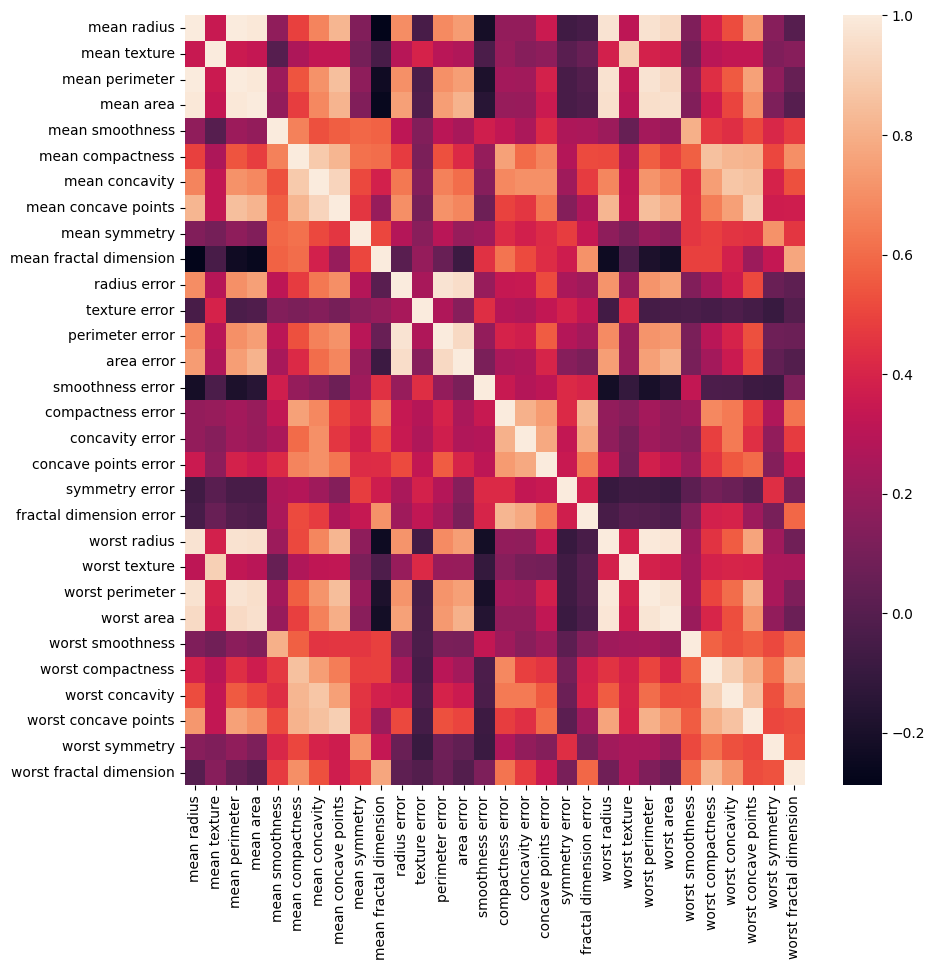

In [64]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr())
plt.show()

We will create models using PCA and those without it. For the latter, we will use the 10 best (by recall score in logistic regression) features. Let us determine these features. We'll make sure to standardize the features before passing them to logistic regression.

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [66]:
features = X_train.columns
pipe = Pipeline([('scaler', StandardScaler()), ('log_reg', LogisticRegression())])
scores = np.zeros((5, len(features))) # kfold defaults to 5 splits
cv = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)
for j, feat in enumerate(features):
    scores[:, j] = cross_val_score(pipe, X_train[feat].values.reshape(-1, 1), y_train, n_jobs=-1, scoring='recall', cv=cv)

best_feats_idx = scores.mean(axis=0).argsort()[-10:]
best_feats = [features[i] for i in best_feats_idx]
best_feats

['worst concavity',
 'mean area',
 'mean concavity',
 'mean radius',
 'mean perimeter',
 'worst area',
 'mean concave points',
 'worst radius',
 'worst perimeter',
 'worst concave points']

Among the most predictive features we found, there is still quite a lot of correlation.

<Axes: >

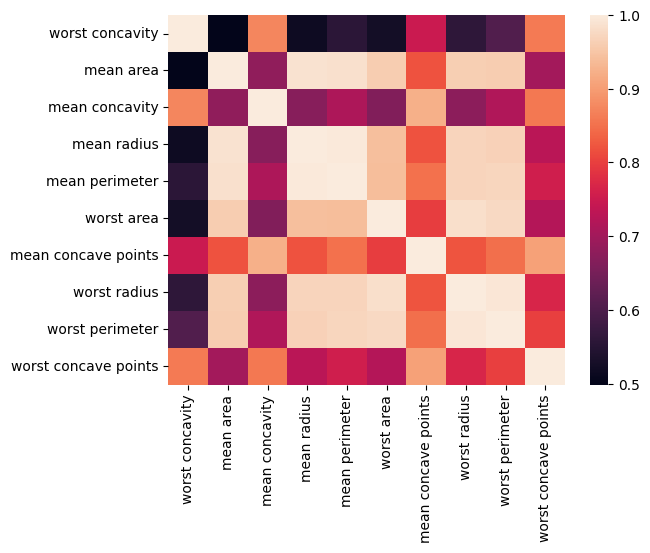

In [67]:
sns.heatmap(X_train[best_feats].corr())

<Axes: >

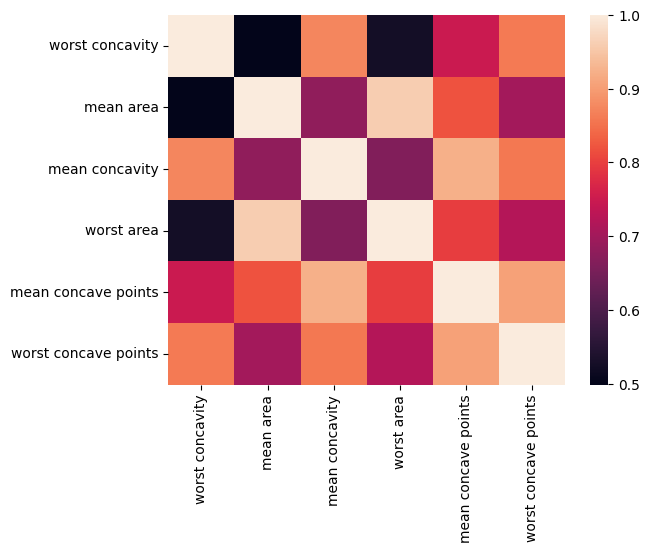

In [68]:
best_feats.remove('mean radius')
best_feats.remove('mean perimeter')
best_feats.remove('worst radius')
best_feats.remove('worst perimeter')
sns.heatmap(X_train[best_feats].corr())

In [69]:
X_train_feats = X_train[best_feats]
X_test_feats = X_test[best_feats]

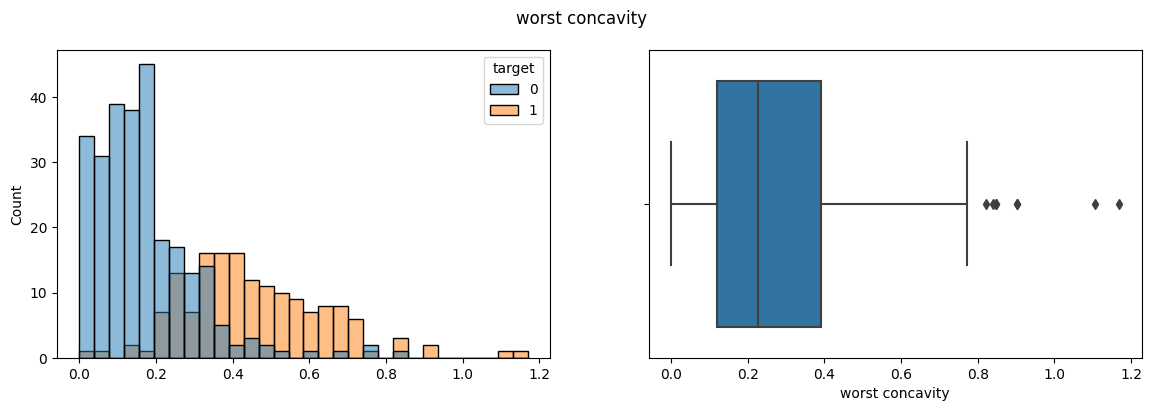

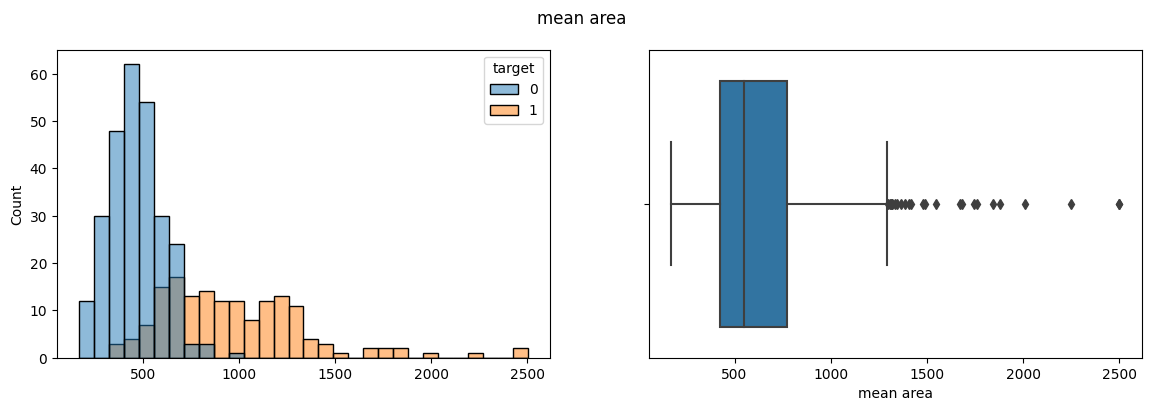

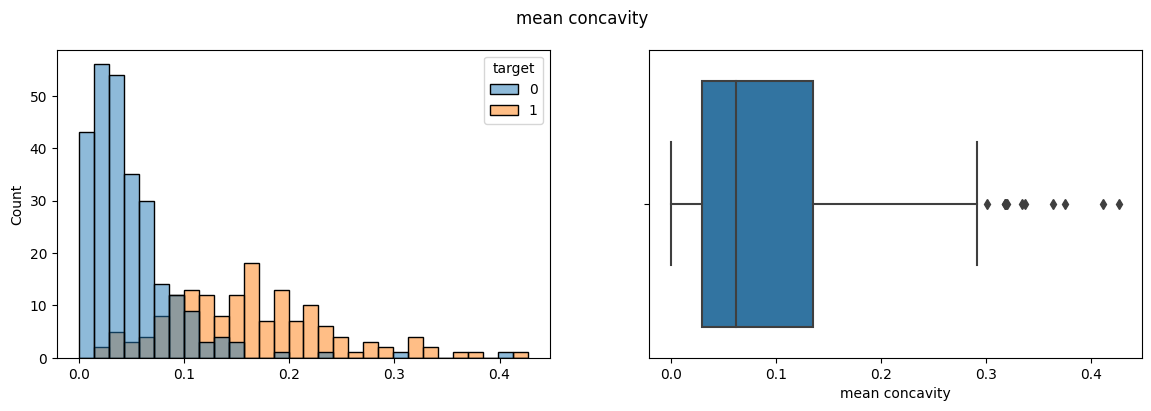

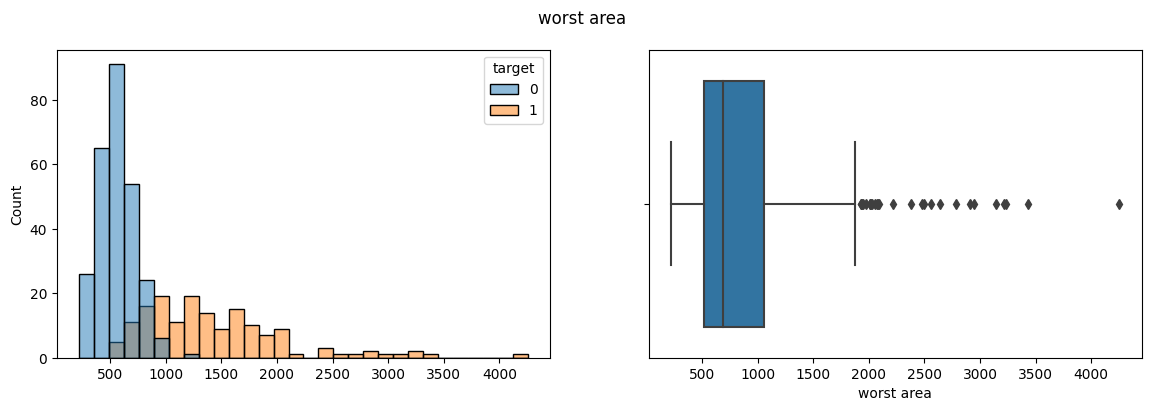

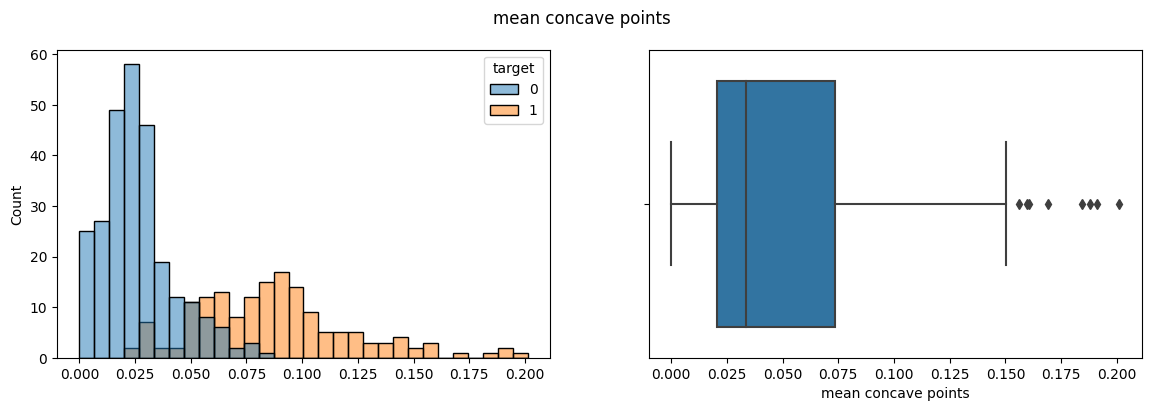

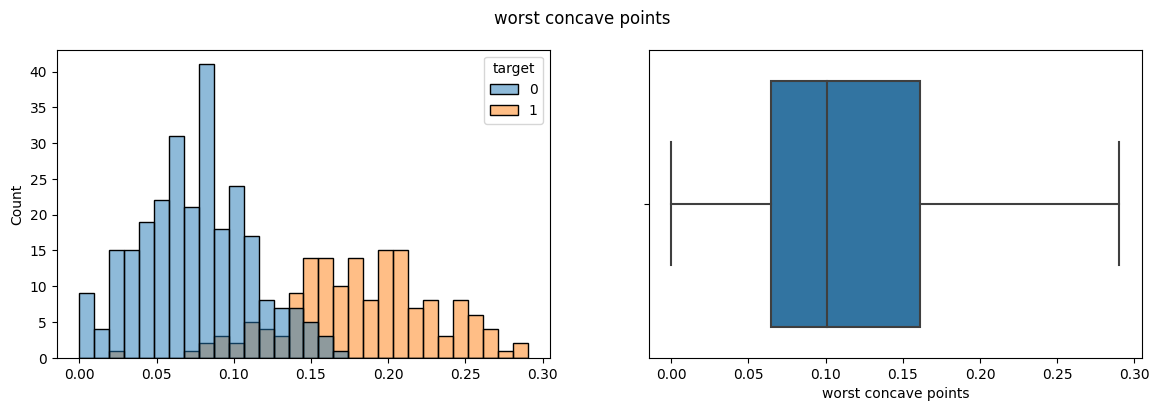

In [70]:
for feat in best_feats:
    fig, axes = plt.subplots(1, 2)
    fig.set_figwidth(14)
    fig.set_figheight(4)
    fig.suptitle(feat)

    sns.histplot(x=X_train[feat].values, hue=y_train, bins=30, ax=axes[0])

    sns.boxplot(x=X_train[feat], ax=axes[1])

    plt.show()

# Models

We work with the non-neural network models first.

In [71]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [72]:
models = [LogisticRegression(), RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), XGBClassifier(), GaussianNB(), KNeighborsClassifier(), SVC()]
pipe_build =[('scaler', StandardScaler())]


We will use the class name of the models to name the items in our <code>Pipeline</code>.

In [73]:
type(models[0]).__name__

'LogisticRegression'

In [74]:
feats_scores = np.zeros((5, len(models)))
for j, model in enumerate(models):
    pipe_build.append((type(model).__name__, model))
    pipe = Pipeline(pipe_build)
    feats_scores[:, j] = cross_val_score(pipe, X_train_feats, y_train, scoring='recall', n_jobs=-1, cv=cv)
    pipe_build.pop()

In [75]:
feats_models_means = feats_scores.mean(axis=0)
feats_models_idx = feats_scores.mean(axis=0).argsort()[-3:]
feats_models = [type(models[i]).__name__ for i in feats_models_idx]
feats_models


['SVC', 'RandomForestClassifier', 'XGBClassifier']

In [76]:
[feats_models_means[i] for i in feats_models_idx]

[0.892741935483871, 0.9116935483870968, 0.9179435483870968]

We now turn to trying out PCA.

In [77]:
from sklearn.decomposition import PCA

We do some hyperparameter tuning for the optimal explained variance.

In [78]:
ev_ratios = np.arange(0.01, 1, 0.01)
ev_scores = np.zeros((5, len(ev_ratios)))
for j, ev in enumerate(ev_ratios):
    pipe_build.append(('pca', PCA(ev)))
    pipe_build.append(('log_reg', LogisticRegression()))
    pipe = Pipeline(pipe_build)

    ev_scores[:, j] = cross_val_score(pipe, X_train, y_train, scoring='recall', n_jobs=-1, cv=cv)
    pipe_build.pop()
    pipe_build.pop()

In [79]:
best_ev = ev_ratios[ev_scores.mean(axis=0).argmax()]
best_ev

0.9400000000000001

In [80]:
pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(best_ev))])
X_train_pca = pca_pipe.fit_transform(X_train)

In [83]:
pca_scores = np.zeros((5, len(models)))
for j, model in enumerate(models):
    pca_scores[:, j] = cross_val_score(model, X_train_pca, y_train, scoring='recall', n_jobs=-1, cv=cv)

In [84]:
pca_models_means = pca_scores.mean(axis=0)
pca_models_idx = pca_scores.mean(axis=0).argsort()[-3:]
pca_models = [type(models[i]).__name__ for i in pca_models_idx]
pca_models

['KNeighborsClassifier', 'SVC', 'LogisticRegression']

In [85]:
[pca_models_means[i] for i in pca_models_idx]

[0.9306451612903226, 0.9433467741935484, 0.9558467741935484]

## Neural networks

In [ ]:
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate

We will try two neural network models. Both employ 2 hidden layers with 64 nodes each and use the sigmoid activation function for the output layer. The two models only differ with the metrics they use. In the first, we optimize for recall and precision. In the second, we optimize for F1 score.

We extract the number of PCA features. We will use this in defining the neural network models later.

In [ ]:
pca_n_feats = X_train_pca.shape[1]
pca_n_feats

9

We now define the neural network skeleton model that'll be used for both the recall/precision and F1 score models.

In [92]:
def nn_model(hidden_layer_dim=64, input_dim=30, mets=['accuracy'], eager=False):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(input_dim, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(hidden_layer_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=mets,
        run_eagerly=eager
    )
    return model

### Recall and precision

In [86]:
nn_rec_prec_clf = KerasClassifier(nn_model, hidden_layer_dim=64, epochs=200, mets=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()], input_dim=pca_n_feats)
nn_rec_prec_scores = cross_validate(nn_rec_prec_clf, X_train_pca, y_train, cv=cv, n_jobs=-1, scoring=['recall', 'precision'])


2023-06-20 11:52:31.894489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-20 11:52:31.897356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-20 11:52:31.898186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-20 11:52:31.906888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/200
Epoch 1/200
Epoch 1/200
Epoch 1/200
11/11 [==============================] - 2s 8ms/step - loss: 0.5072 - recall_8: 0.7087 - precision_8: 0.9184
Epoch 2/200
11/11 [==============================] - 0s 4ms/step - loss: 0.4115 - recall_8: 0.7795 - precision_8: 0.9167
Epoch 3/200
11/11 [==============================] - 0s 5ms/step - loss: 0.3461 - recall_8: 0.7874 - precision_8: 0.9346
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 0.2978 - recall_8: 0.8110 - precision_8: 0.9450
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 0.2625 - recall_8: 0.8189 - precision_8: 0.9720
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 0.2359 - recall_8: 0.8268 - precision_8: 0.9722
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 0.2146 - recall_8: 0.8268 - precision_8: 0.9722
Epoch 8/200
11/11 [==============================] - 0s 5ms/step - loss: 0.1979 - recall_8: 0.8425 - precision_8: 0.9

In [87]:
print(f'recall mean: {nn_rec_prec_scores["test_recall"].mean()}')
print(f'precision mean: {nn_rec_prec_scores["test_precision"].mean()}')
nn_rec_prec_scores

recall mean: 0.9495967741935484
precision mean: 0.975366568914956


{'fit_time': array([20.4059515 , 20.03993511, 23.74700451, 22.97572994, 12.08451843]),
 'score_time': array([0.74131656, 0.44777679, 0.32076621, 0.38766623, 0.14725256]),
 'test_recall': array([0.9375    , 0.9375    , 0.96875   , 0.96875   , 0.93548387]),
 'test_precision': array([0.96774194, 0.90909091, 1.        , 1.        , 1.        ])}

### F1 score

Our custom F1 score function that'll be compiled into our Tensorflow model:

In [ ]:
def f1score(y_true, y_pred):
    prec = tf.keras.metrics.Precision()
    prec.update_state(y_true, y_pred)
    precision = prec.result().numpy()
    rec = tf.keras.metrics.Recall()
    rec.update_state(y_true, y_pred)
    recall = rec.result().numpy()
    return 2*precision*recall/(precision + recall)

Warning: fitting the F1 score NN-model takes a long time (~9 minutes for us) since the model must be run eagerly (since we used <code>numpy</code> functions in the definition of <code>f1score</code>). Lowering <code>epochs</code>remedies this at the cost of a lower F1 score.

In [93]:
nn_f1_clf = KerasClassifier(nn_model, hidden_layer_dim=64, epochs=200, mets=[f1score], input_dim=pca_n_feats, eager=True)
nn_f1_scores = cross_validate(nn_f1_clf, X_train_pca, y_train, cv=cv, n_jobs=-1, scoring=['recall', 'precision'])

Epoch 1/200
Epoch 1/200
Epoch 1/200
Epoch 1/200


Cause: Unable to locate the source code of <function f1score at 0x7fd1160c99e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function f1score at 0x7f672a74fec0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autogr

 3/11 [=======>......................] - ETA: 0s - loss: 0.6497 - f1score: 0.4828

Cause: Unable to locate the source code of <function f1score at 0x7fa14ad4d9e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 5/11 [============>.................] - ETA: 0s - loss: 0.6430 - f1score: 0.4353

Cause: Unable to locate the source code of <function f1score at 0x7fdb7abbfec0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


11/11 [==============================] - 1s 105ms/step - loss: 0.6191 - f1score: 0.5382
Epoch 2/200
11/11 [==============================] - 2s 197ms/step - loss: 0.6737 - f1score: 0.6535
Epoch 2/200
11/11 [==============================] - 1s 99ms/step - loss: 0.5418 - f1score: 0.7123
Epoch 3/200
11/11 [==============================] - 3s 203ms/step - loss: 0.7923 - f1score: 0.2351
Epoch 2/200
11/11 [==============================] - 1s 109ms/step - loss: 0.5818 - f1score: 0.8068
Epoch 3/200
11/11 [==============================] - 4s 270ms/step - loss: 0.7059 - f1score: 0.5480
Epoch 2/200
11/11 [==============================] - 2s 173ms/step - loss: 0.4746 - f1score: 0.7843
Epoch 4/200
11/11 [==============================] - 1s 97ms/step - loss: 0.5114 - f1score: 0.8352
Epoch 4/200
11/11 [==============================] - 2s 164ms/step - loss: 0.6799 - f1score: nan
Epoch 3/200
 1/11 [=>............................] - ETA: 0s - loss: 0.5119 - f1score: 0.7857

/tmp/ipykernel_2946/323177951.py:8: RuntimeWarning: invalid value encountered in double_scalars


11/11 [==============================] - 1s 137ms/step - loss: 0.5685 - f1score: 0.7046
Epoch 3/200
11/11 [==============================] - 1s 100ms/step - loss: 0.4546 - f1score: 0.8338
Epoch 5/200
11/11 [==============================] - 2s 156ms/step - loss: 0.4175 - f1score: 0.8059
Epoch 5/200
11/11 [==============================] - 2s 141ms/step - loss: 0.5895 - f1score: 0.6138
Epoch 4/200
11/11 [==============================] - 1s 118ms/step - loss: 0.4666 - f1score: 0.8515
Epoch 4/200
11/11 [==============================] - 1s 94ms/step - loss: 0.4037 - f1score: 0.8502
Epoch 6/200
11/11 [==============================] - 1s 129ms/step - loss: 0.3650 - f1score: 0.8084
Epoch 6/200
11/11 [==============================] - 1s 97ms/step - loss: 0.3578 - f1score: 0.8575
Epoch 7/200
11/11 [==============================] - 2s 150ms/step - loss: 0.5187 - f1score: 0.7078
Epoch 5/200
11/11 [==============================] - 2s 153ms/step - loss: 0.3922 - f1score: 0.8972
Epoch 5/200
11

Cause: Unable to locate the source code of <function f1score at 0x7fd1146060c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
/tmp/ipykernel_2946/323177951.py:8: RuntimeWarning: invalid value encountered in double_scalars


11/11 [==============================] - 1s 81ms/step - loss: 0.6672 - f1score: nan
Epoch 2/200
11/11 [==============================] - 1s 69ms/step - loss: 0.5647 - f1score: nan
Epoch 3/200
11/11 [==============================] - 1s 64ms/step - loss: 0.4878 - f1score: nan
Epoch 4/200
11/11 [==============================] - 1s 65ms/step - loss: 0.4306 - f1score: 0.6983
Epoch 5/200
11/11 [==============================] - 1s 67ms/step - loss: 0.3842 - f1score: 0.8189
Epoch 6/200
11/11 [==============================] - 1s 119ms/step - loss: 0.3421 - f1score: 0.8416
Epoch 7/200
11/11 [==============================] - 1s 74ms/step - loss: 0.3058 - f1score: 0.8718
Epoch 8/200
11/11 [==============================] - 1s 72ms/step - loss: 0.2728 - f1score: 0.8846
Epoch 9/200
11/11 [==============================] - 1s 69ms/step - loss: 0.2428 - f1score: 0.9013
Epoch 10/200
11/11 [==============================] - 1s 66ms/step - loss: 0.2159 - f1score: 0.9107
Epoch 11/200
11/11 [=========

In [94]:
print(f'recall mean: {nn_f1_scores["test_recall"].mean()}')
print(f'precision mean: {nn_f1_scores["test_precision"].mean()}')
nn_f1_scores

recall mean: 0.9243951612903226
precision mean: 0.9437121212121212


{'fit_time': array([382.20465255, 357.38606906, 382.17231226, 382.21346521,
        199.13688517]),
 'score_time': array([0.27629781, 0.132406  , 0.20846629, 0.19582224, 0.21562862]),
 'test_recall': array([0.90625   , 0.9375    , 0.90625   , 0.96875   , 0.90322581]),
 'test_precision': array([0.96666667, 0.9375    , 1.        , 0.93939394, 0.875     ])}

# Final model

The best performing model on the training data was logistic regression. However, we note that we did not tune most of our models. We will examine what happens when we do so later.

In [95]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [96]:
final_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(best_ev)), ('log_reg', LogisticRegression(n_jobs=-1))])
final_pipe.fit(X_train, y_train)
final_preds = final_pipe.predict(X_test)

In [97]:
# order is [[tn, fp], [fn, tp]]
final_cm = confusion_matrix(y_test, final_preds)
print(f'Random forest recall score: {recall_score(y_test, final_preds)}, precision score: {precision_score(y_test, final_preds)}')
final_cm

Random forest recall score: 0.9811320754716981, precision score: 0.9811320754716981


array([[89,  1],
       [ 1, 52]])

# Misc models

We try out some of the other models.

## Random forests

This is the random forest model built on our selected feature set.

We perform some hyperparameter tuning.

In [116]:
from sklearn.model_selection import GridSearchCV

In [117]:
n_estimators = list(range(50, 350, 50))
min_samples_split = [2, 5, 10, 12]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]

grid = {'n_estimators': n_estimators,
         'min_samples_split': min_samples_split,
         'min_samples_leaf': min_samples_leaf,
         'bootstrap': bootstrap
}

In [118]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=5, n_jobs=-1, scoring='recall')

rf_pipe = Pipeline([('scaler', StandardScaler()), ('grid', grid_search)])

In [119]:
rf_pipe.fit(X_train_feats, y_train)
rf_params = rf_pipe['grid'].best_params_

In [120]:
#rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, bootstrap=False)
rf = RandomForestClassifier(**rf_params)
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', rf)])
rf_pipe.fit(X_train_feats, y_train)
rf_preds = rf_pipe.predict(X_test_feats)

In [122]:
# order is [[tn, fp], [fn, tp]]
rf_cm = confusion_matrix(y_test, rf_preds)
print(f'Random forest recall score: {recall_score(y_test, rf_preds)}, precision score: {precision_score(y_test, rf_preds)}')
rf_cm

Random forest recall score: 0.9433962264150944, precision score: 0.9615384615384616


array([[88,  2],
       [ 3, 50]])

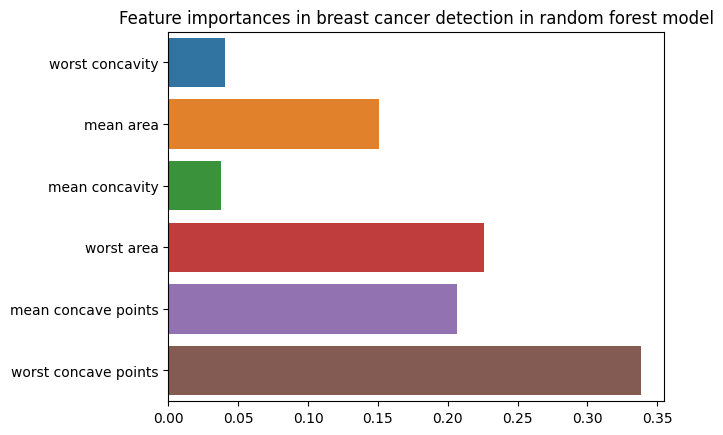

In [123]:
wts = rf_pipe['rf'].feature_importances_
sns.barplot(x=wts, y=X_train_feats.columns)
plt.title('Feature importances in breast cancer detection in random forest model')
plt.show()

### XGBoost

We try a hyperparameter tuned XGBoost on our selected feature set.

In [124]:
from sklearn.model_selection import RandomizedSearchCV

In [125]:
n_estimators = list(range(100, 1100, 100))
learning_rate = np.arange(.1, .25, 0.05)
min_child_weight = [1, 5 ,10]
gamma = [0.5, 1, 1.5, 2, 5]
subsample = [0.6, 0.8, 1.0]
colsample_bytree = [0.6, 0.8, 1]
max_depth = [3, 4, 5]

grid = {'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth,
}

In [126]:
xgb = XGBClassifier()
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=grid, cv=5, n_iter=100, n_jobs=-1, scoring='recall', random_state=RANDOM_STATE)

In [127]:
xgb_pipe = Pipeline([('scaler', StandardScaler()), ('random', random_search)])

In [128]:
xgb_pipe.fit(X_train_feats, y_train)
xgb_cand_params = xgb_pipe['random'].best_params_
offsets = {'subsample': [-0.1, 0, 0.1],
           'n_estimators': [-50, 0, 50],
           'min_child_weight': [-1, 0, 1],
           'learning_rate': [-0.05, 0, 0.05],
           'gamma': [-0.25, 0, 0.25]}

In [129]:
grid = dict()
for key in offsets:
    grid[key] = []
    for offset in offsets[key]:
        grid[key].append(xgb_cand_params[key] + offset)

grid_search = GridSearchCV(estimator=xgb, param_grid=grid, cv=3, n_jobs=-1, scoring='recall')
xgb_pipe = Pipeline([('scaler', StandardScaler()), ('grid', grid_search)])

In [130]:
xgb_pipe.fit(X_train_feats, y_train)
xgb_params = xgb_pipe['grid'].best_params_

/home/k/Programming/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
243 fits failed with the following error:
Traceback (most recent call last):
  File "/home/k/Programming/datascience/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/k/Programming/datascience/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/k/Programming/datascience/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
   

In [131]:
#xgb = XGBClassifier(colsample_bytree=0.7, gamma=1.25, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=250, subsample=0.6)
xgb = XGBClassifier(**xgb_params)
xgb_pipe = Pipeline([('scaler', StandardScaler()), ('xgb', xgb)])

In [132]:
xgb_pipe.fit(X_train_feats, y_train)
xgb_preds = xgb_pipe.predict(X_test_feats)

In [133]:
xgb_cm = confusion_matrix(y_test, xgb_preds)
print(f'XGBoost recall score: {recall_score(y_test, xgb_preds)}, precision score: {precision_score(y_test, xgb_preds)}')
xgb_cm

XGBoost recall score: 0.9433962264150944, precision score: 0.9615384615384616


array([[88,  2],
       [ 3, 50]])

### Neural networks

This is a NN-model optimizing for recall and precision. The data is standardized and run through PCA before reaching the model.

In [99]:
nn_clf = KerasClassifier(nn_model, hidden_layer_dim=64, epochs=200, mets=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()], input_dim=pca_n_feats)
nn_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(best_ev)), ('nn', nn_clf)])
nn_pipe.fit(X_train, y_train)
nn_preds = nn_pipe.predict(X_test)

Epoch 1/200
14/14 [==============================] - 2s 5ms/step - loss: 0.6427 - recall_10: 0.4340 - precision_10: 0.6970
Epoch 2/200
14/14 [==============================] - 0s 6ms/step - loss: 0.5017 - recall_10: 0.5472 - precision_10: 0.9457
Epoch 3/200
14/14 [==============================] - 0s 6ms/step - loss: 0.4098 - recall_10: 0.6164 - precision_10: 0.9608
Epoch 4/200
14/14 [==============================] - 0s 7ms/step - loss: 0.3476 - recall_10: 0.6541 - precision_10: 0.9541
Epoch 5/200
14/14 [==============================] - 0s 6ms/step - loss: 0.3012 - recall_10: 0.7044 - precision_10: 0.9492
Epoch 6/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2680 - recall_10: 0.7799 - precision_10: 0.9466
Epoch 7/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2381 - recall_10: 0.8491 - precision_10: 0.9507
Epoch 8/200
14/14 [==============================] - 0s 6ms/step - loss: 0.2153 - recall_10: 0.8742 - precision_10: 0.9653
Epoch 9/200
14/1

In [100]:
nn_cm = confusion_matrix(y_test, nn_preds)
print(f'Nueral network recall score: {recall_score(y_test, nn_preds)}, precision score: {precision_score(y_test, nn_preds)}')
nn_cm

Nueral network recall score: 1.0, precision score: 0.9636363636363636


array([[88,  2],
       [ 0, 53]])